# Продажи австралийского вина

Известны ежемесячные продажи австралийского вина в тысячах литров с января 1980 по июль 1995, необходимо построить прогноз на следующие три года.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda): #преобразование обратное бокса-кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [9]:
wag = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
wag.columns = ['salary']
wag.head()

,salary
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


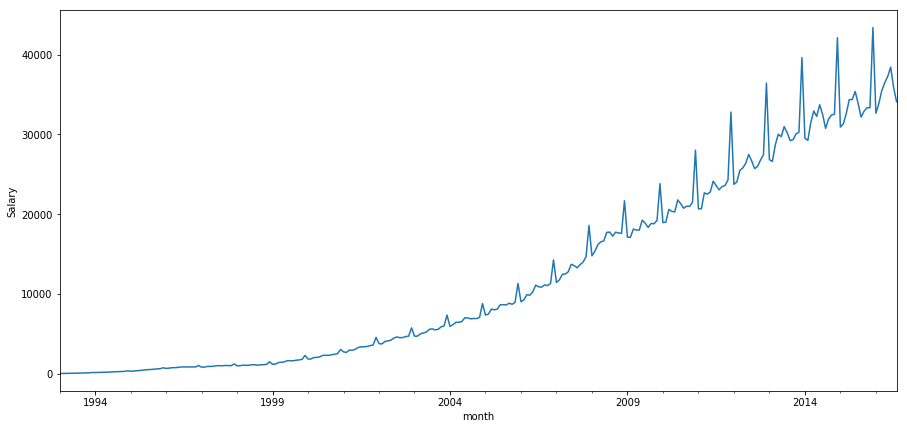

In [11]:
plt.figure(figsize(15,7))
wag.salary.plot()
plt.ylabel('Salary')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

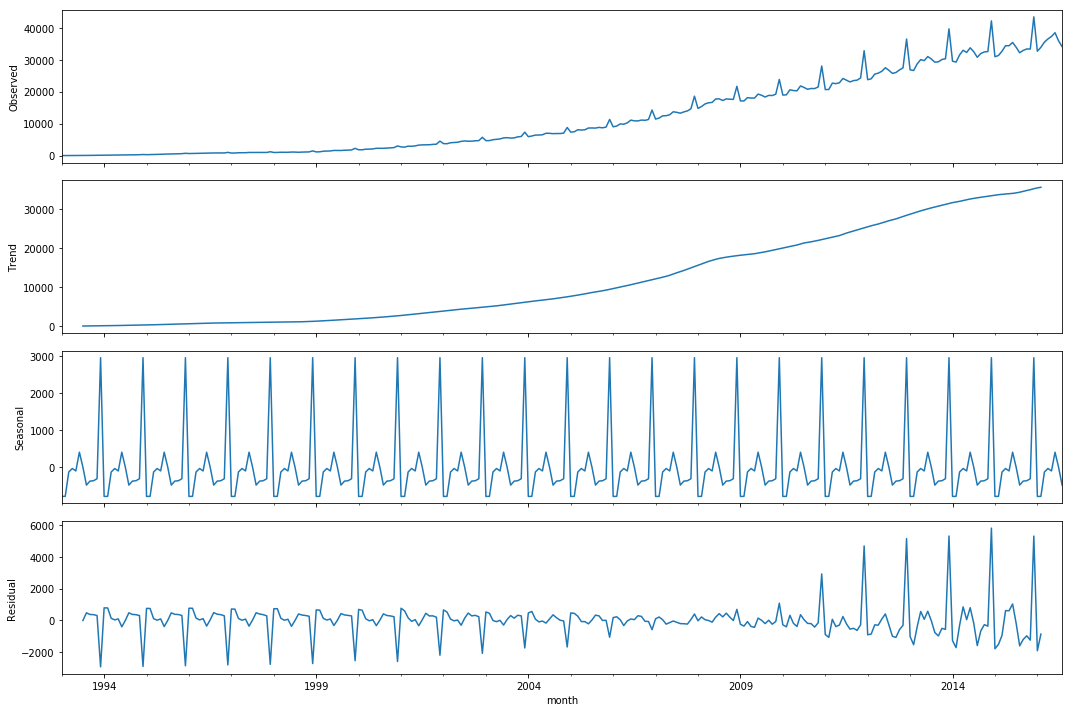

In [12]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wag.salary).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag.salary)[1])

Ряд не стационарный, есть тренд + сезонная компонента (кратная 12)

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


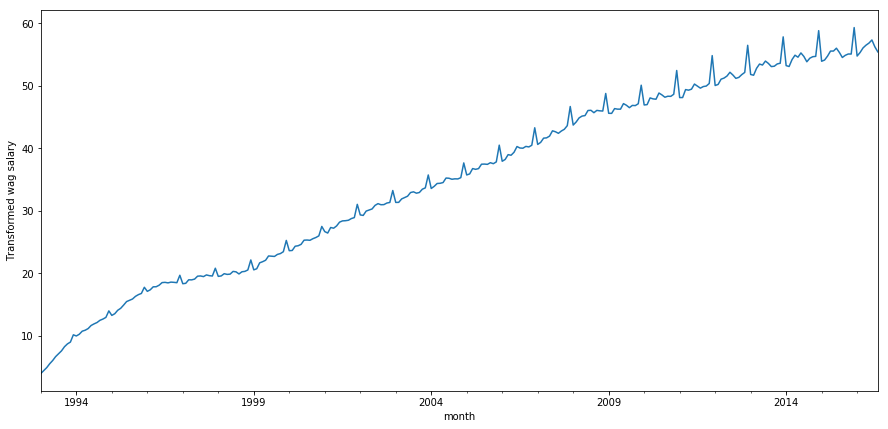

In [13]:
wag['salary_box'], lmbda = stats.boxcox(wag.salary)
plt.figure(figsize(15,7))
wag.salary_box.plot()
plt.ylabel(u'Transformed wag salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag.salary_box)[1])

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу cтационарности. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

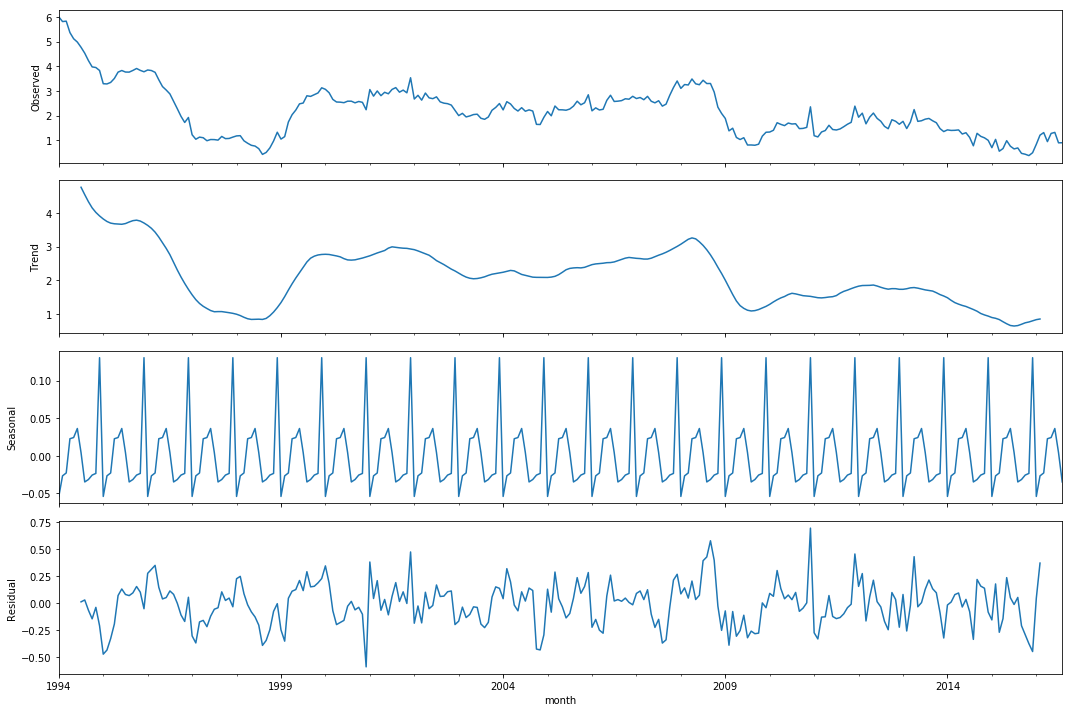

In [16]:
wag['salary_box_diff'] = wag.salary_box - wag.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wag.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag.salary_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

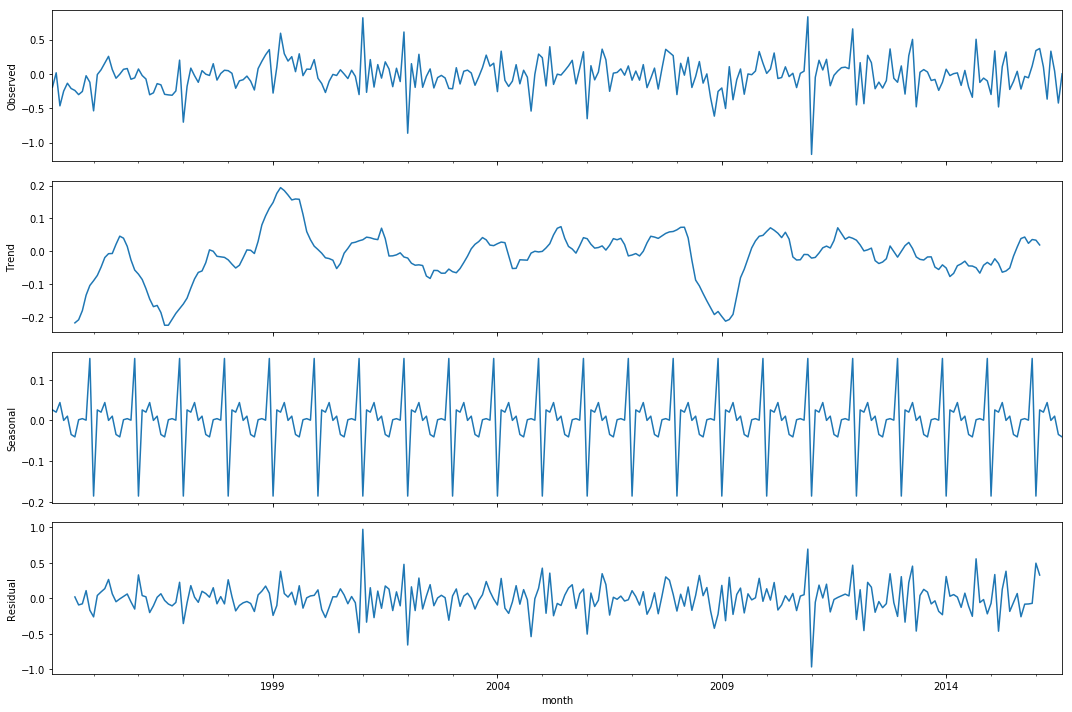

In [17]:
wag['salary_box_diff2'] = wag.salary_box_diff - wag.salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wag.salary_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag.salary_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

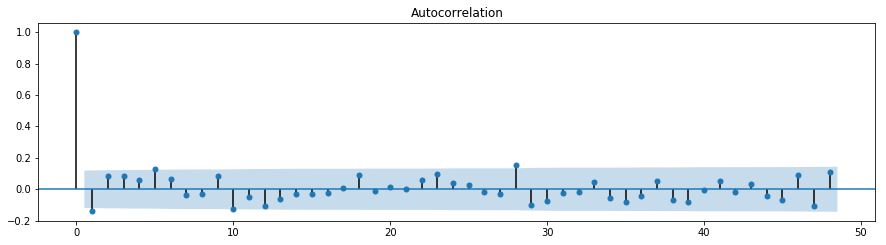

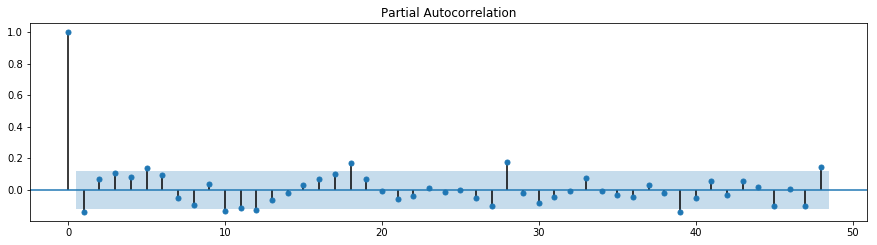

In [18]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wag.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax) #автокорреляция
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wag.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax) #частичная автокорреляция
pylab.show()

Начальные приближения: Q=0, q=1, P=0, p=1

In [19]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 1)
D=1
Qs = range(0, 1)

In [20]:
parameters = product(ps, qs, Ps, Qs) #перебор всех возможных комбинаций от 0 до ps,qs,Ps,Qs
parameters_list = list(parameters)
len(parameters_list)

4

In [21]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wag.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 2.7 s


Если в предыдущей ячейке возникает ошибка, убедитесь, что обновили statsmodels до версии не меньше 0.8.0rc1.

In [22]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
2  (1, 0, 0, 0)  2.625709
1  (0, 1, 0, 0)  3.369832
3  (1, 1, 0, 0)  4.003440
0  (0, 0, 0, 0)  5.241225


Лучшая модель:

In [23]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                   0.687
Date:                            Tue, 05 May 2020   AIC                              2.626
Time:                                    12:42:17   BIC                              9.830
Sample:                                01-01-1993   HQIC                             5.518
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1300      0.048     -2.733      0.006      -0.223      -0.037
sigma2         0.0582      0.004   

Её остатки:

Критерий Стьюдента: p=0.146496
Критерий Дики-Фуллера: p=0.000000


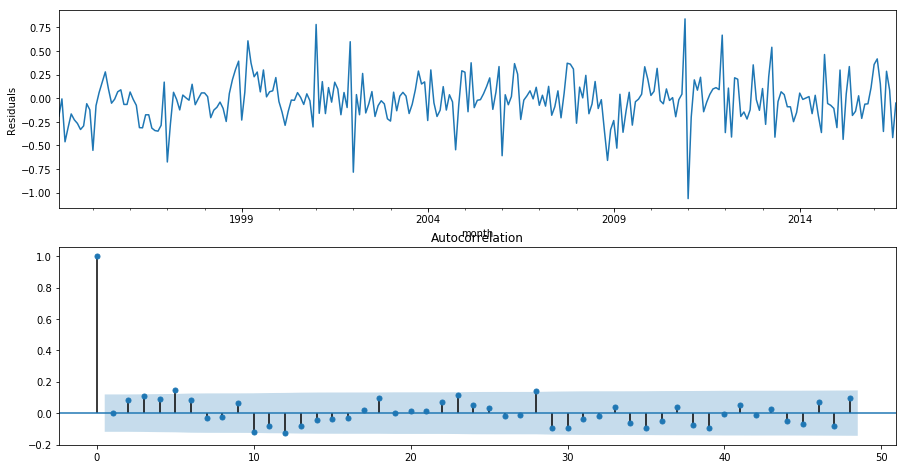

In [24]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

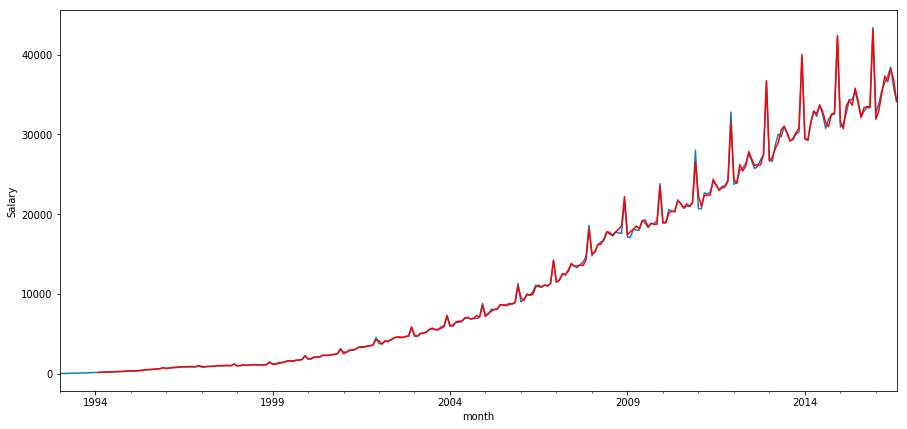

In [25]:
wag['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wag.salary.plot()
wag.model[13:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

In [26]:
wag.tail()

,salary,salary_box,salary_box_diff,salary_box_diff2,model
month,,,,,
2016-04-01,36497.0,56.526742,0.942729,-0.366210,37314.389069
2016-05-01,37270.0,56.860441,1.275065,0.332336,36609.717587
2016-06-01,38447.0,57.358885,1.316994,0.041929,38244.036046
2016-07-01,35888.0,56.260153,0.893671,-0.423323,36845.960010
2016-08-01,34095.0,55.455409,0.896620,0.002949,34209.028091


In [27]:
wag.shape

(284, 5)

### Прогноз

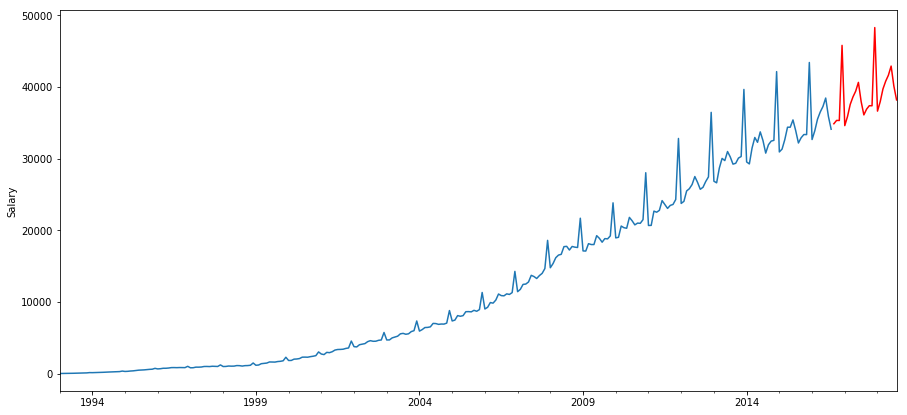

In [29]:
wag2 = wag[['salary']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= wag2.columns)
wag2 = pd.concat([wag2, future])
wag2['forecast'] = invboxcox(best_model.predict(start=284, end=308), lmbda)

plt.figure(figsize(15,7))
wag2.salary.plot()
wag2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()